<p style="align: center;"><img align=center src="https://drive.google.com/uc?export=view&id=1I2wUTT12p5bX3RCku_T_82aD4tkY9LVY" width=600 height=480/></p>
<h3 style="text-align: center;"><b>Школа глубокого обучения ФПМИ МФТИ</b></h3>

<h3 style="text-align: center;"><b>Домашнее задание. Сегментация изображений</b></h3>


В этом задании вам предстоит решить задачу сегментации медицинских снимков. Часть кода с загрузкой данных написана за вас. Всю содержательную сторону вопроса вам нужно заполнить самостоятельно. Задание оценивается из 15 баллов.

Обратите внимание, что отчёт по заданию стоит целых 6 баллов. Он вынесен в отдельный пункт в конце тетради. Это сделано для того, чтобы тетрадь была оформлена как законченный документ о проведении экспериментов. Неотъемлемой составляющей отчёта является ответ на следующие вопросы:

* Что было сделано? Что получилось реализовать, что не получилось?
* Какие результаты ожидалось получить?
* Какие результаты были достигнуты?
* Чем результаты различных подходов отличались друг от друга и от бейзлайна (если таковой присутствует)?




---


1. Для начала мы скачаем датасет: [ADDI project](https://www.fc.up.pt/addi/ph2%20database.html).

<table><tr><td>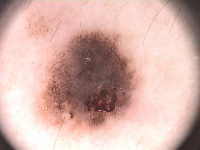</td><td>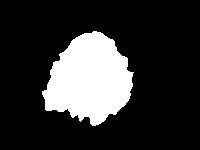</td></tr></table>

2. Разархивируем .rar файл.
3. Обратите внимание, что папка  `PH2 Dataset images` должна лежать там же где и ipynb notebook.

Это фотографии двух типов **поражений кожи:** меланома и родинки.
В данном задании мы не будем заниматься их классификацией, а будем **сегментировать** их.

In [ ]:
!wget -c https://www.dropbox.com/s/8lqrloi0mxj2acu/PH2Dataset.rar

# если по ссылке слишком много запросов, датасет можно скачать с kaggle: https://www.kaggle.com/datasets/kanametov/ph2dataset

In [ ]:
!pip install kaggle

In [2]:
from google.colab import files
uploaded = files.upload()

Saving kaggle.json to kaggle.json


In [3]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d kanametov/ph2dataset
!unzip ph2dataset.zip

In [10]:
!ls

kaggle.json  PH2Dataset  ph2dataset.zip  sample_data


In [9]:
get_ipython().system_raw("unrar x PH2Dataset.rar")

Стуктура датасета у нас следующая:

    IMD_002/
        IMD002_Dermoscopic_Image/
            IMD002.bmp
        IMD002_lesion/
            IMD002_lesion.bmp
        IMD002_roi/
            ...
    IMD_003/
        ...
        ...

 Здесь `X.bmp` — изображение, которое нужно сегментировать, `X_lesion.bmp` — результат сегментации.

Для загрузки датасета можно использовать skimage: [`skimage.io.imread()`](https://scikit-image.org/docs/dev/api/skimage.io.html)

In [87]:
images = []
lesions = []
from skimage.io import imread
import os

root_dir = 'PH2Dataset/PH2_Dataset'
for patient_folder in os.listdir(root_dir):
  patient_path = os.path.join(root_dir, patient_folder)
  for subdir in os.listdir(patient_path):
    subdir_path = os.path.join(patient_path, subdir)
    if subdir.endswith('_Dermoscopic_Image'):
      for file in os.listdir(subdir_path):
        if file.endswith('.bmp'):
          images.append(imread(os.path.join(subdir_path, file)))
    elif subdir.endswith('_lesion'):
      for file in os.listdir(subdir_path):
        if file.endswith('.bmp'):
          lesions.append(imread(os.path.join(subdir_path, file)))

Изображения имеют разные размеры. Давайте изменим их размер на $256\times256 $ пикселей. Для изменения размера изображений можно использовать [`skimage.transform.resize()`](https://scikit-image.org/docs/dev/api/skimage.transform.html#skimage.transform.resize).
Эта функция также автоматически нормализует изображения в диапазоне $[0,1]$.


In [88]:
from skimage.transform import resize
size = (256, 256)
X = [resize(x, size, mode='constant', anti_aliasing=True,) for x in images]
Y = [resize(y, size, mode='constant', anti_aliasing=False) > 0.5 for y in lesions]

In [89]:
import numpy as np
X = np.array(X, np.float32)
Y = np.array(Y, np.float32)
print(f'Loaded {len(X)} images')

Loaded 200 images


In [90]:
len(lesions)

200

Чтобы убедиться, что все корректно, мы нарисуем несколько изображений

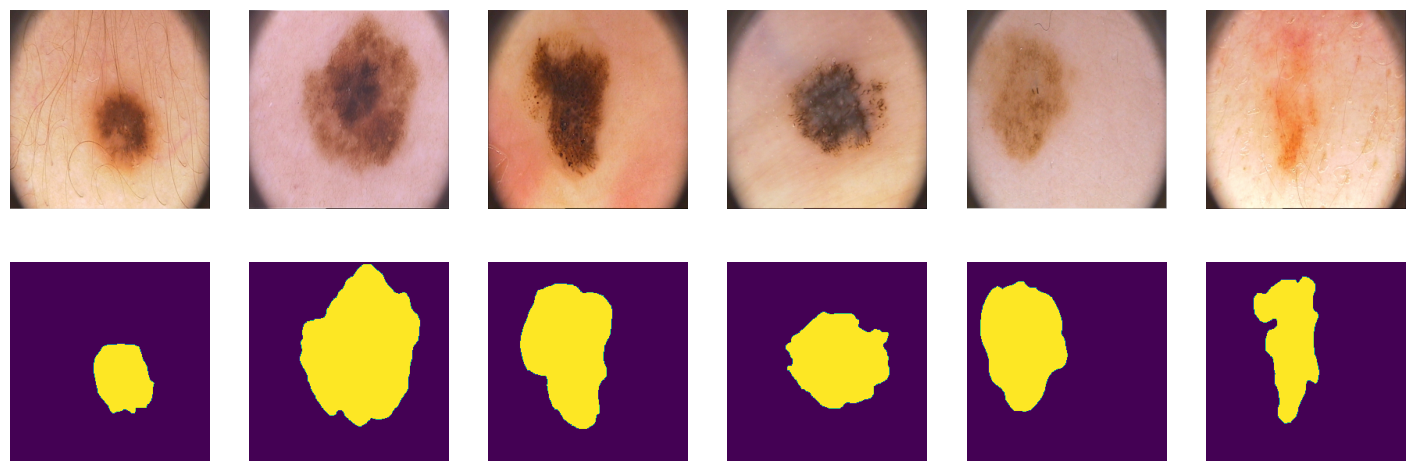

In [15]:
import matplotlib.pyplot as plt
from IPython.display import clear_output

plt.figure(figsize=(18, 6))
for i in range(6):
    plt.subplot(2, 6, i+1)
    plt.axis("off")
    plt.imshow(X[i])

    plt.subplot(2, 6, i+7)
    plt.axis("off")
    plt.imshow(Y[i])
plt.show();

Разделим наши 200 картинок на 100/50/50
 для обучения, валидации и теста соответственно

In [91]:
ix = np.random.choice(len(X), len(X), False)
tr, val, ts = np.split(ix, [100, 150])

In [92]:
print(len(tr), len(val), len(ts))

100 50 50


#### PyTorch DataLoader

In [93]:
from torch.utils.data import DataLoader
batch_size = 25
data_tr = DataLoader(list(zip(np.rollaxis(X[tr], 3, 1), Y[tr, np.newaxis])),
                     batch_size=batch_size, shuffle=True)
data_val = DataLoader(list(zip(np.rollaxis(X[val], 3, 1), Y[val, np.newaxis])),
                      batch_size=batch_size, shuffle=True)
data_ts = DataLoader(list(zip(np.rollaxis(X[ts], 3, 1), Y[ts, np.newaxis])),
                     batch_size=batch_size, shuffle=True)

In [94]:
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


# Реализация различных архитектур:
Ваше задание будет состоять в том, чтобы написать несколько нейросетевых архитектур для решения задачи семантической сегментации. Сравнить их по качеству на тесте и испробовать различные лосс функции для них.

-----------------------------------------------------------------------------------------

# SegNet [2 балла]

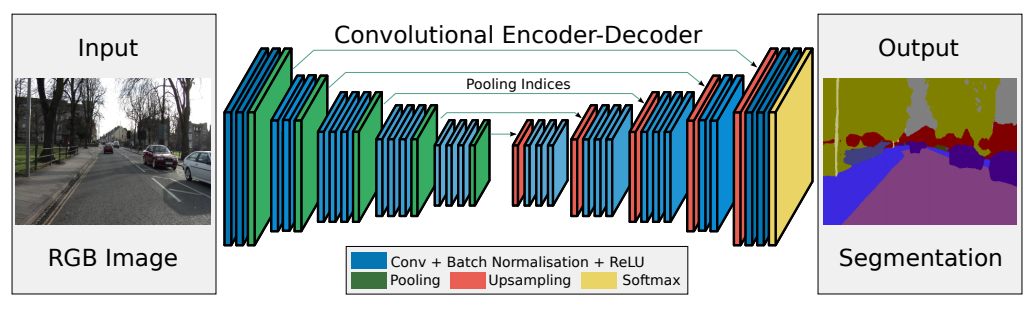

* Badrinarayanan, V., Kendall, A., & Cipolla, R. (2015). [SegNet: A deep convolutional
encoder-decoder architecture for image segmentation](https://arxiv.org/pdf/1511.00561.pdf)

Внимательно посмотрите из чего состоит модель и для чего выбраны те или иные блоки.

In [95]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models
import torch.optim as optim
from time import time

from matplotlib import rcParams
rcParams['figure.figsize'] = (15,4)

In [96]:
class SegNet(nn.Module):
    def __init__(self):
        super().__init__()

        # encoder (downsampling)
        # Each enc_conv/dec_conv block should look like this:
        # nn.Sequential(
        #     nn.Conv2d(...),
        #     ... (2 or 3 conv layers with relu and batchnorm),
        # )
        self.enc_conv0 = nn.Sequential(
            nn.Conv2d(3, 64, 3, padding = 1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 64, 3, padding = 1),
            nn.BatchNorm2d(64),
            nn.ReLU()
        )
        self.pool0 = nn.MaxPool2d(2, 2, return_indices= True)  # 256 -> 128

        self.enc_conv1 = nn.Sequential(
            nn.Conv2d(64, 128, 3, padding = 1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 128, 3, padding = 1),
            nn.BatchNorm2d(128),
            nn.ReLU()
        )
        self.pool1 = nn.MaxPool2d(2, 2, return_indices= True)# 128 -> 64

        self.enc_conv2 = nn.Sequential(
            nn.Conv2d(128, 256, 3, padding = 1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(256, 256, 3, padding = 1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(256, 256, 3, padding = 1),
            nn.BatchNorm2d(256),
            nn.ReLU()
        )
        self.pool2 = nn.MaxPool2d(2, 2, return_indices= True) # 64 -> 32

        self.enc_conv3 = nn.Sequential(
            nn.Conv2d(256, 512, 3, padding = 1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(512, 512, 3, padding = 1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(512, 512, 3, padding = 1),
            nn.BatchNorm2d(512),
            nn.ReLU()
        )
        self.pool3 = nn.MaxPool2d(2, 2, return_indices= True) # 32 -> 16

        # bottleneck
        self.bottleneck_conv = nn.Sequential(
            nn.Conv2d(512, 512, 3, padding = 1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(512, 512, 3, padding = 1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(512, 512, 3, padding = 1),
            nn.BatchNorm2d(512),
            nn.ReLU()
        )

        # decoder (upsampling)
        self.upsample0 = nn.MaxUnpool2d(2, 2) # 16 -> 32
        self.dec_conv0 = nn.Sequential(
            nn.Conv2d(512, 512, 3, padding = 1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(512, 512, 3, padding = 1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(512, 256, 3, padding = 1),
            nn.BatchNorm2d(256),
            nn.ReLU()
        )

        self.upsample1 = nn.MaxUnpool2d(2, 2) # 32 -> 64
        self.dec_conv1 = nn.Sequential(
            nn.Conv2d(256, 256, 3, padding = 1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(256, 256, 3, padding = 1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(256, 128, 3, padding = 1),
            nn.BatchNorm2d(128),
            nn.ReLU()
        )

        self.upsample2 = nn.MaxUnpool2d(2, 2) # 64 -> 128
        self.dec_conv2 = nn.Sequential(
            nn.Conv2d(128, 128, 3, padding = 1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 64, 3, padding = 1),
            nn.BatchNorm2d(64),
            nn.ReLU()
        )

        self.upsample3 = nn.MaxUnpool2d(2, 2) # 128 -> 256
        self.dec_conv3 = nn.Sequential(
            nn.Conv2d(64, 64, 3, padding = 1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 1, 3, padding = 1)
        )

    def forward(self, x):
        # encoder
        e0 = self.enc_conv0(x)
        x, e0_indc = self.pool0(e0)
        e1 = self.enc_conv1(x)
        x, e1_indc = self.pool1(e1)
        e2 = self.enc_conv2(x)
        x, e2_indc = self.pool2(e2)
        e3 = self.enc_conv3(x)
        x, e3_indc = self.pool3(e3)

        # bottleneck
        b = self.bottleneck_conv(x)

        # decoder
        d0 = self.upsample0(b, e3_indc)
        x = self.dec_conv0(d0)
        d1 = self.upsample1(x, e2_indc)
        x = self.dec_conv1(d1)
        d2 = self.upsample2(x, e1_indc)
        x = self.dec_conv2(d2)
        d3 = self.upsample3(x, e0_indc)
        x = self.dec_conv3(d3)  # no activation
        return x

## Метрика

В данном разделе предлагается использовать следующую метрику для оценки качества:

$I o U=\frac{\text {target } \cap \text { prediction }}{\text {target } \cup{prediction }}$

Пересечение (A ∩ B) состоит из пикселей, найденных как в маске предсказания, так и в основной маске истины, тогда как объединение (A ∪ B) просто состоит из всех пикселей, найденных либо в маске предсказания, либо в целевой маске.


Для примера посмотрим на истину (слева) и предсказание (справа):
![alt text](https://www.jeremyjordan.me/content/images/2018/05/target_prediction.png)


Тогда пересечение и объединение будет выглядеть так:

![alt text](https://www.jeremyjordan.me/content/images/2018/05/intersection_union.png)

In [97]:
def iou_pytorch(outputs: torch.Tensor, labels: torch.Tensor):
    # You can comment out this line if you are passing tensors of equal shape
    # But if you are passing output from UNet or something it will most probably
    # be with the BATCH x 1 x H x W shape
    outputs = outputs.squeeze(1).byte()  # BATCH x 1 x H x W => BATCH x H x W
    labels = labels.squeeze(1).byte()
    SMOOTH = 1e-8
    intersection = (outputs & labels).float().sum((1, 2))  # Will be zero if Truth=0 or Prediction=0
    union = (outputs | labels).float().sum((1, 2))         # Will be zzero if both are 0

    iou = (intersection + SMOOTH) / (union + SMOOTH)  # We smooth our devision to avoid 0/0

    thresholded = torch.clamp(20 * (iou - 0.5), 0, 10).ceil() / 10  # This is equal to comparing with thresolds

    return thresholded  #

## Функция потерь [1 балл]

Не менее важным, чем построение архитектуры, является определение **оптимизатора** и **функции потерь.**

Функция потерь - это то, что мы пытаемся минимизировать. Многие из них могут быть использованы для задачи бинарной семантической сегментации.

Популярным методом для бинарной сегментации является *бинарная кросс-энтропия*, которая задается следующим образом:

$$\mathcal L_{BCE}(y, \hat y) = -\sum_i \left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

где $y$ это  таргет желаемого результата и $\hat y$ является выходом модели. $\sigma$ - это [*логистическая* функция](https://en.wikipedia.org/wiki/Sigmoid_function), который преобразует действительное число $\mathbb R$ в вероятность $[0,1]$.

Однако эта потеря страдает от проблем численной нестабильности. Самое главное, что $\lim_{x\rightarrow0}\log(x)=\infty$ приводит к неустойчивости в процессе оптимизации. Рекомендуется посмотреть следующее [упрощение](https://www.tensorflow.org/api_docs/python/tf/nn/sigmoid_cross_entropy_with_logits). Эта функция эквивалентна первой и не так подвержена численной неустойчивости:

$$\mathcal L_{BCE} = \hat y - y\hat y + \log\left(1+\exp(-\hat y)\right).$$

In [99]:
from math import log, exp
def bce_loss(y_real, y_pred):
    y_pred = torch.sigmoid(y_pred)
    return torch.mean(y_pred - y_real * y_pred + torch.log(torch.exp(-y_pred) + 1))

## Тренировка [1 балл]

Мы определим цикл обучения в функции, чтобы мы могли повторно использовать его.

In [100]:
def train(model, opt, loss_fn, epochs, data_tr, data_val):
    X_val, Y_val = next(iter(data_val))

    train_loss_hist = []
    val_loss_hist = []
    test_score_hist = []
    for epoch in range(epochs):
        tic = time()
        print('* Epoch %d/%d' % (epoch+1, epochs))

        avg_loss = 0
        model.train()  # train mode
        for X_batch, Y_batch in data_tr:
            # data to device
            X_batch = X_batch.to(device)
            Y_batch = Y_batch.to(device)
            # set parameter gradients to zero
            opt.zero_grad()

            # forward
            Y_pred = model(X_batch)
            loss = loss_fn(Y_batch, Y_pred) # forward-pass
            loss.backward()  # backward-pass
            opt.step()  # update weights

            # calculate loss to show the user
            avg_loss += loss / len(data_tr)
        toc = time()
        print('loss: %f' % avg_loss)

        train_loss_hist.append(avg_loss.tolist())
        # show intermediate results
        model.eval()  # testing mode

        with torch.no_grad():
            val_loss = 0
            for X_val, Y_val in data_val:

                Y_hat = model(X_val.to(device)).detach().cpu() # detach and put into cpu
                val_loss += loss_fn(Y_val, Y_hat) / len(data_val)

        val_loss_hist.append(val_loss.tolist())

        test_score_hist.append(score_model(model, iou_pytorch, data_ts))
        # Visualize tools
        clear_output(wait=True)
        for k in range(6):
            plt.subplot(3, 6, k+1)
            plt.imshow(np.rollaxis(X_val[k].numpy(), 0, 3), cmap='gray')
            plt.title('Real')
            plt.axis('off')

            plt.subplot(3, 6, k+7)
            plt.imshow(Y_hat[k, 0], cmap='gray')
            plt.title('Output')
            plt.axis('off')

            plt.subplot(3, 6, k+13)
            plt.imshow(np.rollaxis(Y_val[k].numpy(), 0, 3), cmap='gray')
            plt.title('Mask')
            plt.axis('off')

        plt.suptitle('%d / %d - loss: %f' % (epoch+1, epochs, avg_loss))
        plt.show()

    return train_loss_hist, val_loss_hist, test_score_hist

## Инференс [1 балл]

После обучения модели эту функцию можно использовать для прогнозирования сегментации на новых данных:

In [101]:
def predict(model, data):
    model.eval()  # testing mode
    Y_pred = [ X_batch for X_batch, _ in data]
    return np.array(Y_pred)

In [102]:
def score_model(model, metric, data):
    model.eval()  # testing mode
    scores = 0
    for X_batch, Y_label in data:
        Y_pred = torch.sigmoid(model(X_batch.to(device)))
        Y_pred = torch.where(Y_pred > 0.5, 1, 0)
        scores += metric(Y_pred, Y_label.to(device)).mean().item()

    return scores/len(data)

## Основной момент: обучение

Обучите вашу модель. Обратите внимание, что обучать необходимо до сходимости. Если указанного количества эпох (20) не хватило, попробуйте изменять количество эпох до сходимости алгоритма. Сходимость определяйте по изменению функции потерь на валидационной выборке.
 С параметрами оптимизатора можно спокойно играть, пока вы не найдете лучший вариант для себя.


In [103]:
model = SegNet().to(device)

In [112]:
import gc
model_dice = None
torch.cuda.empty_cache()
gc.collect()
torch.cuda.empty_cache()

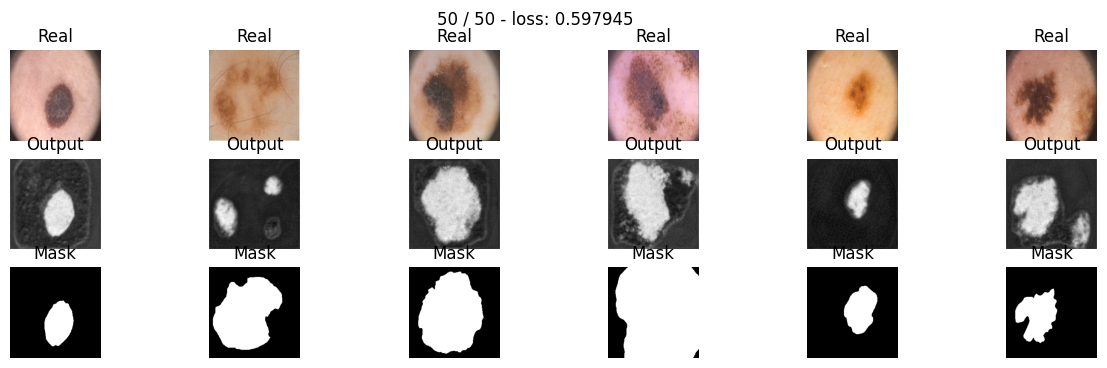

In [106]:
max_epochs = 50
segnet_bce_hist = []
optimaizer = optim.Adam(model.parameters())
t_loss, v_loss, t_score = train(model, optimaizer, bce_loss, max_epochs, data_tr, data_val)
segnet_bce_hist.append(t_loss)
segnet_bce_hist.append(v_loss)
segnet_bce_hist.append(t_score)

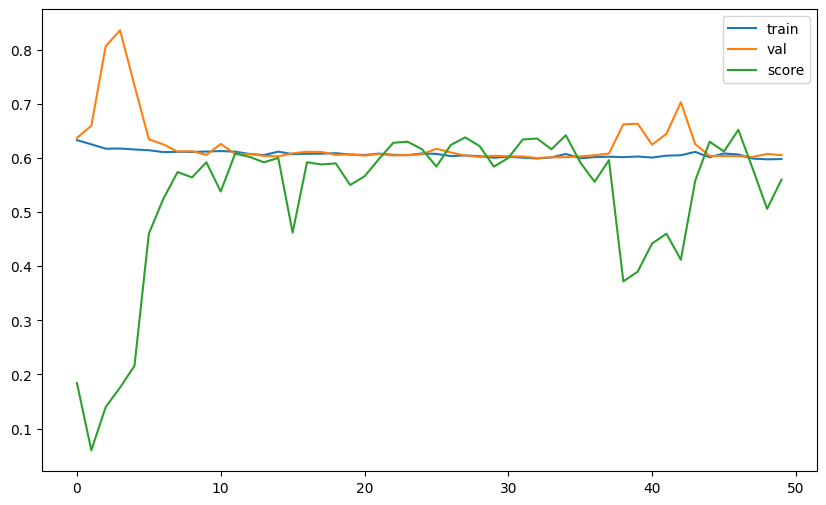

0.6520000100135803


In [107]:
plt.figure(figsize=(10, 6))
plt.plot([float(loss) for loss in segnet_bce_hist[0]], label="train")
plt.plot([float(loss) for loss in segnet_bce_hist[1]], label="val")
plt.plot([float(loss) for loss in segnet_bce_hist[2]], label="score")
plt.legend()
plt.show()
print(max(segnet_bce_hist[2]))

In [118]:
print('Лучший score был на %d эпохе' % segnet_bce_hist[2].index(max(segnet_bce_hist[2])))

Лучший score был на 46 эпохе


Ответьте себе на вопрос: не переобучается ли моя модель?

Ответ: немного переобучается после 46 эпохи.

-----------------------------------------------------------------------------------------

## Дополнительные функции потерь [2 балла]

 В данном разделе вам потребуется имплементировать две функции потерь:
 DICE и Focal loss.
 Если у вас что-то не учится, велика вероятность, что вы ошиблись или учите слишком мало эпох, прежде чем бить тревогу попробуйте перебрать различные варианты и убедитесь, что во всех других сетапах сеть достигает желанного результата. СПОЙЛЕР: учиться она будет при всех лоссах, предложенных в этом задании.


**1. Dice coefficient:** Учитывая две маски $X$ и $Y$, общая метрика для измерения расстояния между этими двумя масками задается следующим образом:

$$D(X,Y)=\frac{2|X\cap Y|}{|X|+|Y|}$$

Эта функция не является дифференцируемой, но это необходимое свойство для градиентного спуска. В данном случае мы можем приблизить его с помощью:

$$\mathcal L_D(X,Y) = 1-\frac{1}{256 \times 256} \times \frac{\sum_i2X_iY_i}{\sum_iX_i+Y_i}.$$

Не забудьте подумать о численной нестабильности, возникающей в математической формуле.


In [113]:
def dice_loss(y_real, y_pred):
    SMOOTH = 0.05
    y_pred = torch.sigmoid(y_pred)
    res = 0
    for xp, xr in zip(y_pred, y_real):
        xp = xp[0].squeeze(0)
        xr = xr[0].squeeze(0)
        num = 2 * xp * xr + SMOOTH
        den = xp + xr + SMOOTH
        res += 1 - torch.sum(num / den) / 256 ** 2
    print("loss y batcha = ", res / len(y_pred))
    return res / len(y_pred)

Проводим тестирование:

In [115]:
model_dice = SegNet().to(device)

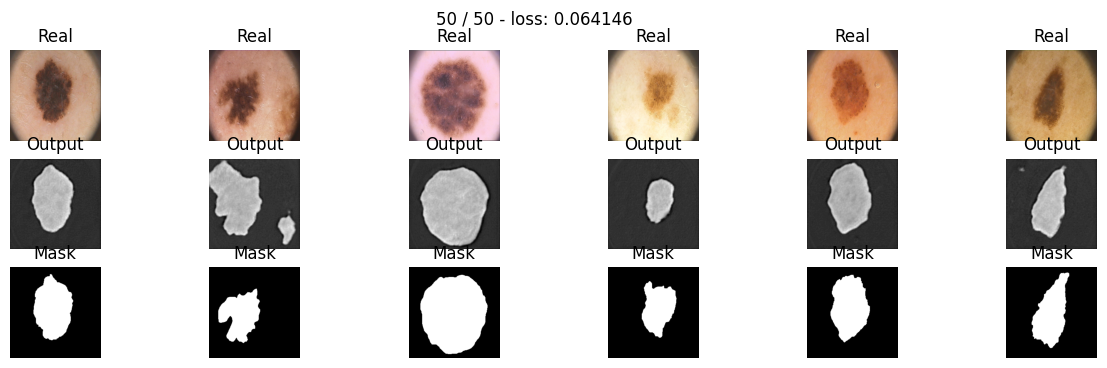

In [116]:
max_epochs = 50
segnet_dice_hist = []
optimaizer = optim.Adam(model_dice.parameters())
v_loss, t_loss, t_score = train(model_dice, optimaizer, dice_loss, max_epochs, data_tr, data_val)
segnet_dice_hist.append(v_loss)
segnet_dice_hist.append(t_loss)
segnet_dice_hist.append(t_score)

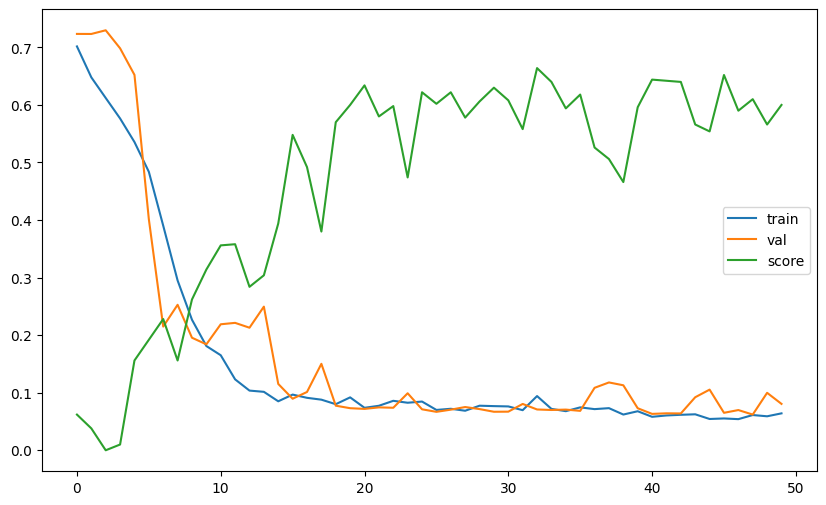

0.664000004529953


In [117]:
plt.figure(figsize=(10, 6))
plt.plot([float(loss) for loss in segnet_dice_hist[0]], label="train")
plt.plot([float(loss) for loss in segnet_dice_hist[1]], label="val")
plt.plot([float(loss) for loss in segnet_dice_hist[2]], label="score")
plt.legend()
plt.show()
print(max(segnet_dice_hist[2]))

In [119]:
print('Лучший score был на %d эпохе' % segnet_dice_hist[2].index(max(segnet_dice_hist[2])))

Лучший score был на 32 эпохе


[**2. Focal loss:**](https://arxiv.org/pdf/1708.02002.pdf)

Окей, мы уже с вами умеем делать BCE loss:

$$\mathcal L_{BCE}(y, \hat y) = -\sum_i \left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

Проблема с этой потерей заключается в том, что она имеет тенденцию приносить пользу классу **большинства** (фоновому) по отношению к классу **меньшинства** ( переднему). Поэтому обычно применяются весовые коэффициенты к каждому классу:

$$\mathcal L_{wBCE}(y, \hat y) = -\sum_i \alpha_i\left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

Традиционно вес $\alpha_i$ определяется как обратная частота класса этого пикселя $i$, так что наблюдения миноритарного класса весят больше по отношению к классу большинства.

Еще одним недавним дополнением является взвешенный пиксельный вариант, которая взвешивает каждый пиксель по степени уверенности, которую мы имеем в предсказании этого пикселя.

$$\mathcal L_{focal}(y, \hat y) = -\sum_i \left[\left(1-\sigma(\hat y_i)\right)^\gamma y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

Зафиксируем значение $\gamma=2$.

--------------------------------------------------------------------------------


In [128]:
import gc
torch.cuda.empty_cache()
gc.collect()

0

In [129]:
def focal_loss(y_real, y_pred, eps = 1e-8, gamma = 2):
    y_pred = torch.sigmoid(y_pred)
    return torch.mean(-(torch.pow((1. - y_pred), gamma) * y_real * torch.log(y_pred + eps) + (1 - y_real) * torch.log(1 - y_pred + eps)))

In [130]:
model_focal = SegNet().to(device)

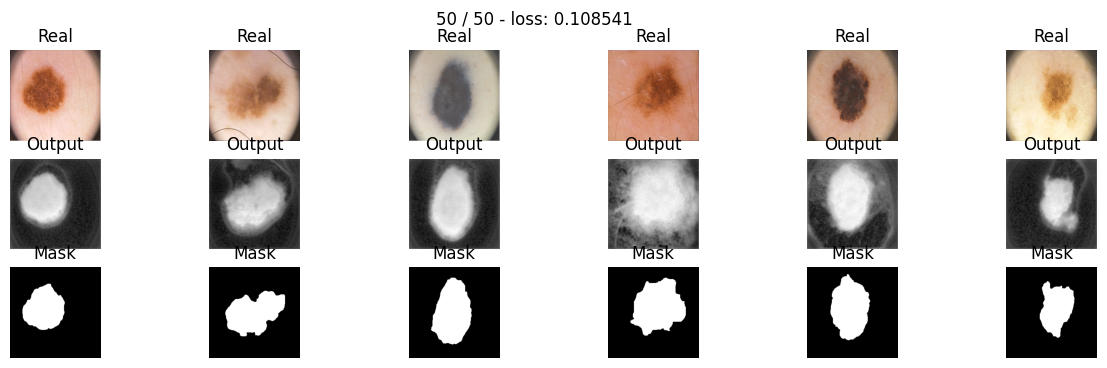

In [131]:
max_epochs = 50
segnet_focal_hist  = []
optimaizer = optim.Adam(model_focal.parameters())
v_loss, t_loss, t_score = train(model_focal, optimaizer, focal_loss, max_epochs, data_tr, data_val)
segnet_focal_hist.append(v_loss)
segnet_focal_hist.append(t_loss)
segnet_focal_hist.append(t_score)

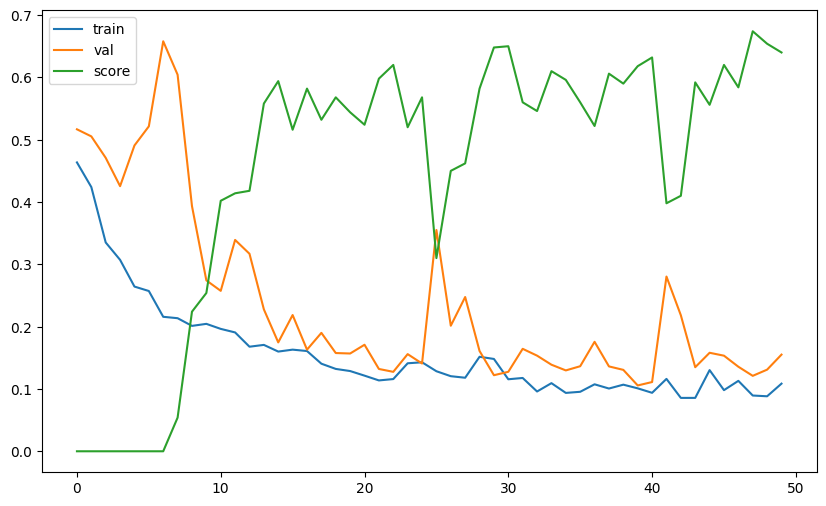

0.6739999949932098


In [132]:
plt.figure(figsize=(10, 6))
plt.plot([float(loss) for loss in segnet_focal_hist[0]], label="train")
plt.plot([float(loss) for loss in segnet_focal_hist[1]], label="val")
plt.plot([float(loss) for loss in segnet_focal_hist[2]], label="score")
plt.legend()
plt.show()
print(max(segnet_focal_hist[2]))

In [125]:
print('Лучший score был на %d эпохе' % segnet_focal_hist[2].index(max(segnet_focal_hist[2])))

Лучший score был на 41 эпохе


----------------------------------------------------------------------------------------------

## [BONUS] Мир сегментационных лоссов [5 баллов]

В данном блоке предлагаем вам написать одну функцию потерь самостоятельно. Для этого необходимо прочитать статью и имплементировать ее. Кроме тако провести численное сравнение с предыдущими функциями.
Какие варианты?

1) Можно учесть Total Variation
2) Lova
3) BCE но с Soft Targets (что-то типа label-smoothing для многослассовой классификации)
4) Любой другой

* [Physiological Inspired Deep Neural Networks for Emotion Recognition](https://ieeexplore.ieee.org/stamp/stamp.jsp?arnumber=8472816&tag=1)". IEEE Access, 6, 53930-53943.

* [Boundary loss for highly unbalanced segmentation](https://arxiv.org/abs/1812.07032)

* [Tversky loss function for image segmentation using 3D fully convolutional deep networks](https://arxiv.org/abs/1706.05721)

* [Correlation Maximized Structural Similarity Loss for Semantic Segmentation](https://arxiv.org/abs/1910.08711)

* [Topology-Preserving Deep Image Segmentation](https://papers.nips.cc/paper/8803-topology-preserving-deep-image-segmentation)

Так как Тверский лосс очень похож на данные выше, то за него будет проставлено только 3 балла (при условии, если в модели нет ошибок при обучении). Постарайтесь сделать что-то интереснее.

In [133]:
from scipy.ndimage import distance_transform_edt

def boundary_loss(y_real, y_pred):
    y_pred = torch.sigmoid(y_pred)
    a = 0.01
    dice_loss_res = torch.mean(torch.ones_like(y_real * y_pred) - (2 * y_real * y_pred + 1e-10) / (y_real + y_pred + 1e-10))
    boundary_loss = 0
    for y_real_im, y_pred_im in zip(y_real, y_pred):
        mask = torch.squeeze(y_real_im, 0).cpu()
        negmask = torch.ones_like(mask) - mask
        dist_mask = torch.tensor(distance_transform_edt(negmask)) * negmask - torch.tensor((distance_transform_edt(mask) - 1)) * mask
        if y_pred_im.get_device() != -1:
            dist_mask = dist_mask.to(device)
        boundary_loss += torch.mean(y_pred_im * dist_mask)
    print(dice_loss_res, " ",boundary_loss / len(y_real))
    res = dice_loss_res + a * (boundary_loss / len(y_real))
    return res

In [134]:
import gc
model_boundary = None
gc.collect()
torch.cuda.empty_cache()

In [135]:
model_boundary = SegNet().to(device)

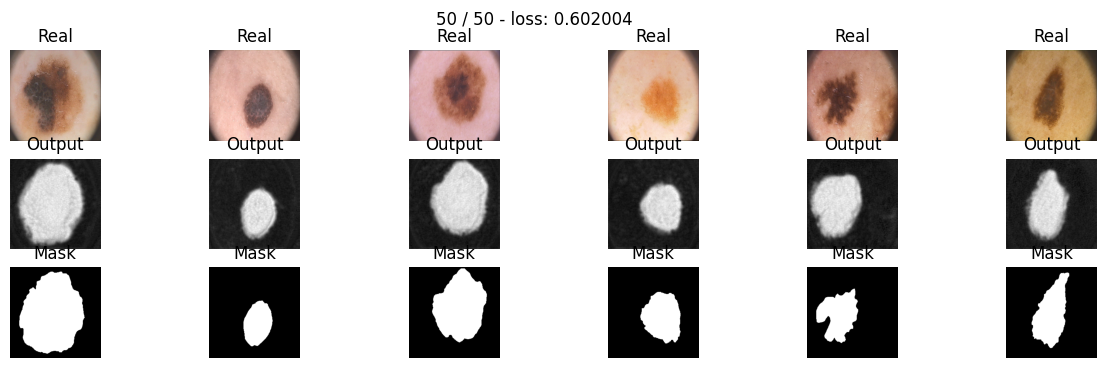

In [136]:
max_epochs = 50
segnet_boundary_hist  = []
optimaizer = optim.Adam(model_boundary.parameters())
v_loss, t_loss, t_score = train(model_boundary, optimaizer, boundary_loss, max_epochs, data_tr, data_val)
segnet_boundary_hist.append(v_loss)
segnet_boundary_hist.append(t_loss)
segnet_boundary_hist.append(t_score)

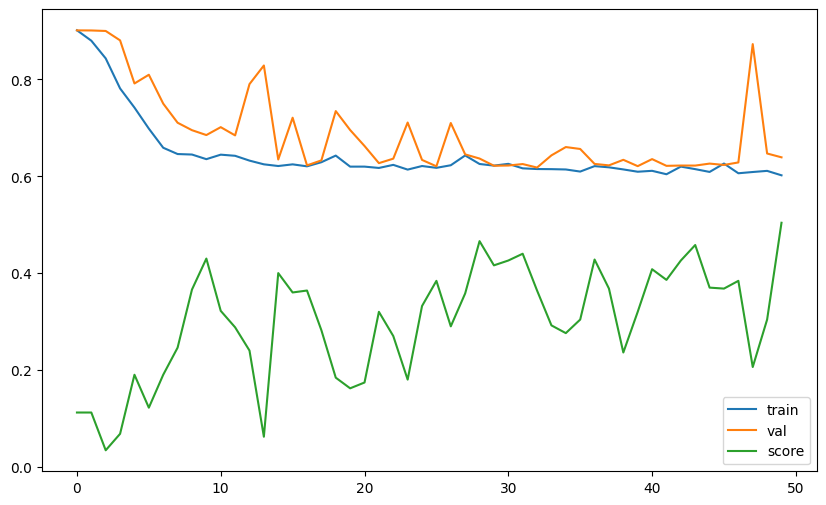

In [137]:
plt.figure(figsize=(10, 6))
plt.plot([float(loss) for loss in segnet_boundary_hist[0]], label="train")
plt.plot([float(loss) for loss in segnet_boundary_hist[1]], label="val")
plt.plot([float(loss) for loss in segnet_boundary_hist[2]], label="score")
plt.legend()
plt.show()

In [138]:
print(max(segnet_boundary_hist[2]))

0.5040000230073929


-----------------------------------------------------------------------------------------

# U-Net [2 балла]

[**U-Net**](https://arxiv.org/abs/1505.04597) — это архитектура нейронной сети, которая получает изображение и выводит его. Первоначально он был задуман для семантической сегментации (как мы ее будем использовать), но он настолько успешен, что с тех пор используется в других контекстах. Получая на вход медицинское изображение, он выведет изображение в оттенках серого, где интенсивность каждого пикселя зависит от вероятности того, что этот пиксель принадлежит интересующей нас области.

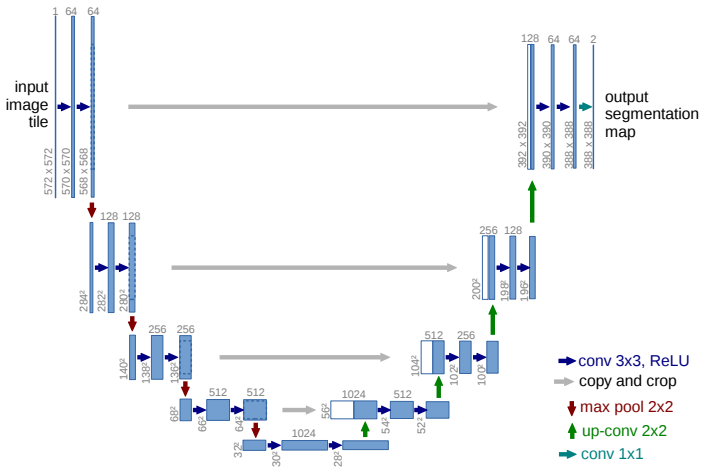

У нас в архитектуре все так же существует энкодер и декодер, как в **SegNet**, но отличительной особеностью данной модели являются *skip-conenctions*, соединяющие части декодера и энкодера. То есть для того чтобы передать на вход декодера тензор, мы конкатенируем симметричный выход с энкодера и выход предыдущего слоя декодера.

* Ronneberger, Olaf, Philipp Fischer, and Thomas Brox. "[U-Net: Convolutional networks for biomedical image segmentation.](https://arxiv.org/pdf/1505.04597.pdf)" International Conference on Medical image computing and computer-assisted intervention. Springer, Cham, 2015.

In [146]:
class UNet(nn.Module):
    def __init__(self):
        super().__init__()

        # encoder (downsampling)
        # Each enc_conv/dec_conv block should look like this:
        # nn.Sequential(
        #     nn.Conv2d(...),
        #     ... (2 or 3 conv layers with relu and batchnorm),
        # )
        self.enc_conv0 = nn.Sequential(
            nn.Conv2d(3, 64, 3, padding = 1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 64, 3, padding = 1),
            nn.BatchNorm2d(64),
            nn.ReLU()
        )
        self.pool0 = nn.MaxPool2d(2, 2, return_indices= True)  # 256 -> 128

        self.enc_conv1 = nn.Sequential(
            nn.Conv2d(64, 128, 3, padding = 1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 128, 3, padding = 1),
            nn.BatchNorm2d(128),
            nn.ReLU()
        )
        self.pool1 = nn.MaxPool2d(2, 2, return_indices= True)# 128 -> 64

        self.enc_conv2 = nn.Sequential(
            nn.Conv2d(128, 256, 3, padding = 1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(256, 256, 3, padding = 1),
            nn.BatchNorm2d(256),
            nn.ReLU()
        )
        self.pool2 = nn.MaxPool2d(2, 2, return_indices= True) # 64 -> 32

        self.enc_conv3 = nn.Sequential(
            nn.Conv2d(256, 512, 3, padding = 1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(512, 512, 3, padding = 1),
            nn.BatchNorm2d(512),
            nn.ReLU()
        )
        self.pool3 = nn.MaxPool2d(2, 2, return_indices= True) # 32 -> 16

        # bottleneck
        self.bottleneck_conv = nn.Sequential(
            nn.Conv2d(512, 1024, 3, padding = 1),
            nn.BatchNorm2d(1024),
            nn.ReLU(),
            nn.Conv2d(1024, 512, 3, padding = 1),
            nn.BatchNorm2d(512),
            nn.ReLU()
        )

        # decoder (upsampling)
        self.upsample0 = nn.MaxUnpool2d(2, 2) # 16 -> 32
        self.dec_conv0 = nn.Sequential(
            nn.Conv2d(1024, 512, 3, padding = 1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(512, 256, 3, padding = 1),
            nn.BatchNorm2d(256),
            nn.ReLU()
        )

        self.upsample1 = nn.MaxUnpool2d(2, 2) # 32 -> 64
        self.dec_conv1 = nn.Sequential(
            nn.Conv2d(512, 256, 3, padding = 1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(256, 128, 3, padding = 1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
        )

        self.upsample2 = nn.MaxUnpool2d(2, 2) # 64 -> 128
        self.dec_conv2 = nn.Sequential(
            nn.Conv2d(256, 128, 3, padding = 1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 64, 3, padding = 1),
            nn.BatchNorm2d(64),
            nn.ReLU()
        )

        self.upsample3 = nn.MaxUnpool2d(2, 2) # 128 -> 256
        self.dec_conv3 = nn.Sequential(
            nn.Conv2d(128, 64, 3, padding = 1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 64, 3, padding = 1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 1, 1)
        )

    def forward(self, x):
        # encoder
        e0 = self.enc_conv0(x)
        x, e0_indc = self.pool0(e0)

        e1 = self.enc_conv1(x)
        x, e1_indc = self.pool1(e1)

        e2 = self.enc_conv2(x)
        x, e2_indc = self.pool2(e2)

        e3 = self.enc_conv3(x)
        x, e3_indc = self.pool3(e3)

        # bottleneck
        b = self.bottleneck_conv(x)

        # decoder

        d0 = self.dec_conv0(torch.cat((self.upsample0(b, e3_indc), e3), dim=1))
        d1 = self.dec_conv1(torch.cat((self.upsample1(d0, e2_indc), e2), dim=1))
        d2 = self.dec_conv2(torch.cat((self.upsample2(d1, e1_indc), e1), dim=1))
        d3 = self.dec_conv3(torch.cat((self.upsample3(d2, e0_indc), e0), dim=1))
        return d3

In [144]:
import gc
unet_model = None
torch.cuda.empty_cache()
gc.collect()
torch.cuda.empty_cache()

In [147]:
unet_model = UNet().to(device)

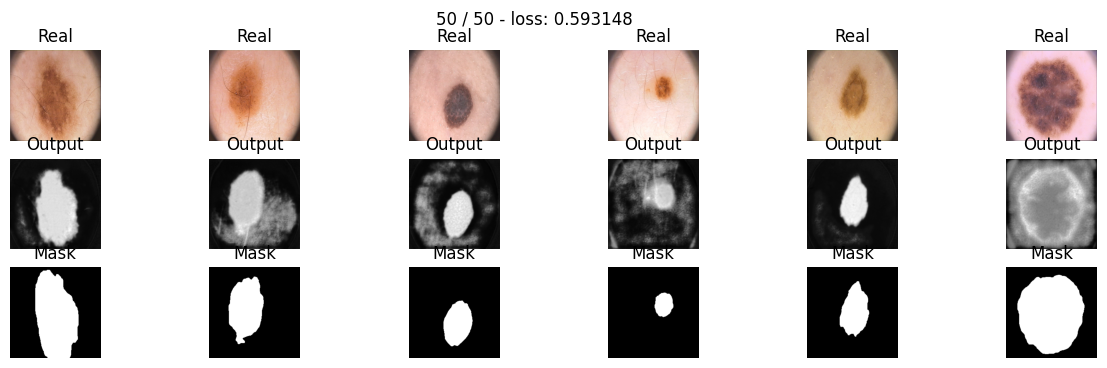

In [148]:
unet_bce_hist = []
max_epochs = 50
optimaizer = optim.Adam(unet_model.parameters())
v_loss, t_loss, t_score = train(unet_model, optimaizer, bce_loss, max_epochs, data_tr, data_val)
unet_bce_hist.append(v_loss)
unet_bce_hist.append(t_loss)
unet_bce_hist.append(t_score)

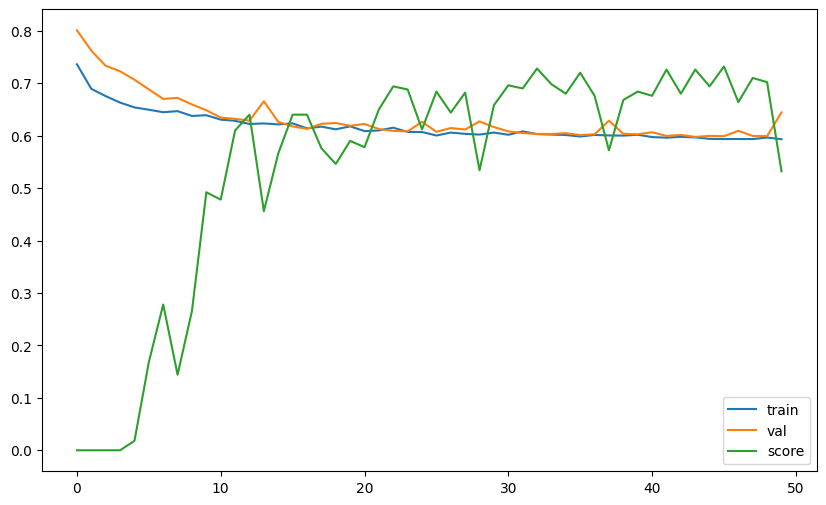

In [149]:
plt.figure(figsize=(10, 6))
plt.plot([float(loss) for loss in unet_bce_hist[0]], label="train")
plt.plot([float(loss) for loss in unet_bce_hist[1]], label="val")
plt.plot([float(loss) for loss in unet_bce_hist[2]], label="score U-Net bce_loss")
plt.legend()
plt.show()

In [150]:
print(max(unet_bce_hist[2]))

0.7320000231266022


In [151]:
unet_model = UNet().to(device)

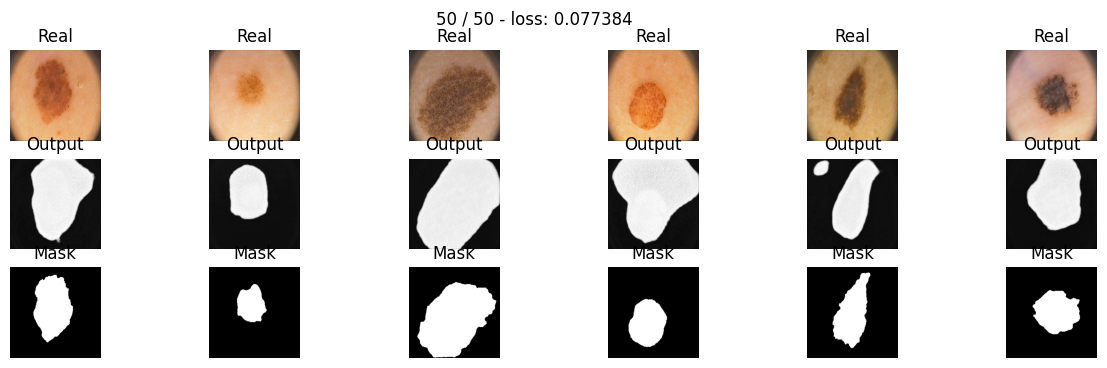

In [152]:
unet_dice_hist = []
max_epochs = 50
optimaizer = optim.Adam(unet_model.parameters())
v_loss, t_loss, t_score = train(unet_model, optimaizer, dice_loss, max_epochs, data_tr, data_val)
unet_dice_hist.append(v_loss)
unet_dice_hist.append(t_loss)
unet_dice_hist.append(t_score)

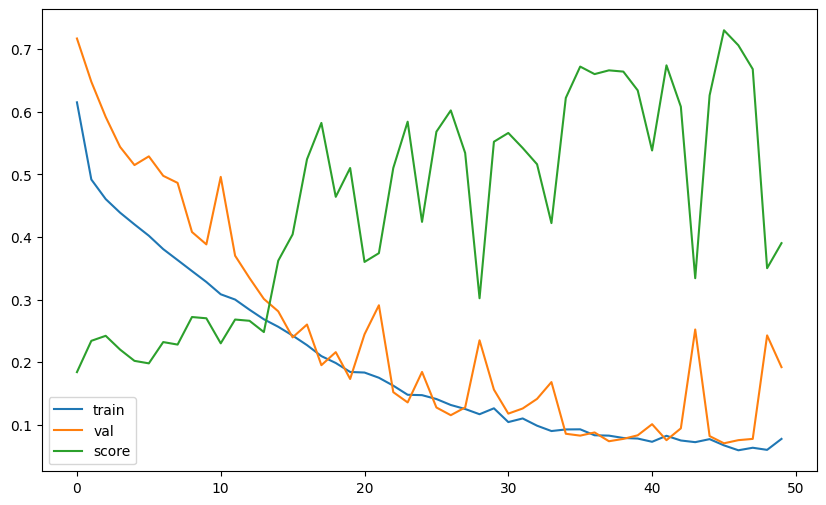

In [153]:
plt.figure(figsize=(10, 6))
plt.plot([float(loss) for loss in unet_dice_hist[0]], label="train")
plt.plot([float(loss) for loss in unet_dice_hist[1]], label="val")
plt.plot([float(loss) for loss in unet_dice_hist[2]], label="score")
plt.legend()
plt.show()

In [154]:
print(max(unet_dice_hist[2]))

0.7299999594688416


In [155]:
unet_model = UNet().to(device)

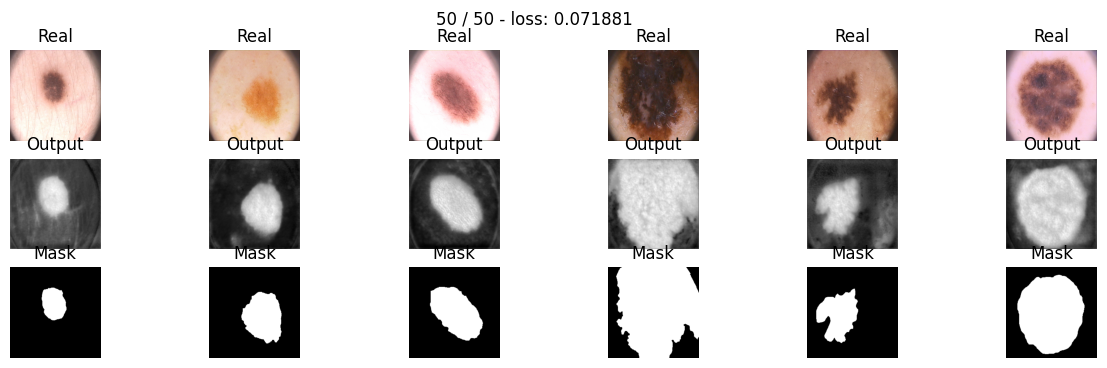

In [156]:
unet_focal_hist = []
max_epochs = 50
optimaizer = optim.Adam(unet_model.parameters())
v_loss, t_loss, t_score = train(unet_model, optimaizer, focal_loss, max_epochs, data_tr, data_val)
unet_focal_hist.append(v_loss)
unet_focal_hist.append(t_loss)
unet_focal_hist.append(t_score)

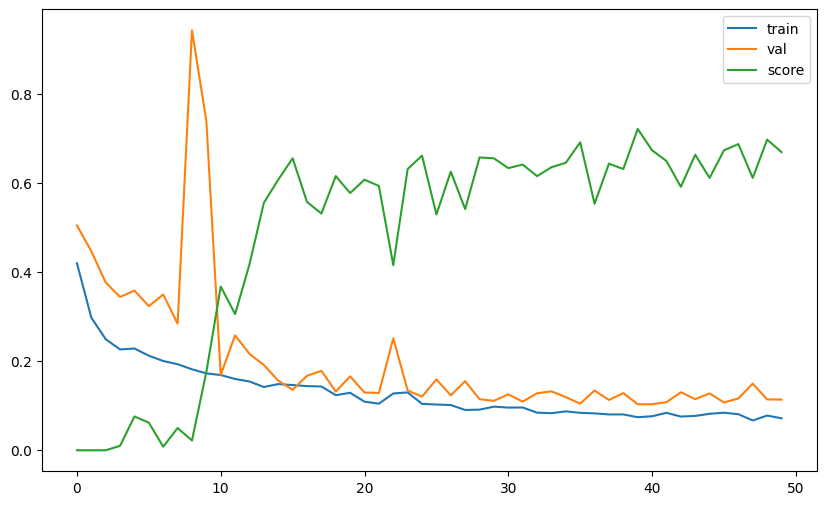

In [157]:
plt.figure(figsize=(10, 6))
plt.plot([float(loss) for loss in unet_focal_hist[0]], label="train")
plt.plot([float(loss) for loss in unet_focal_hist[1]], label="val")
plt.plot([float(loss) for loss in unet_focal_hist[2]], label="score")
plt.legend()
plt.show()

In [158]:
print(max(unet_focal_hist[2]))

0.722000002861023


In [159]:
unet_model = UNet().to(device)

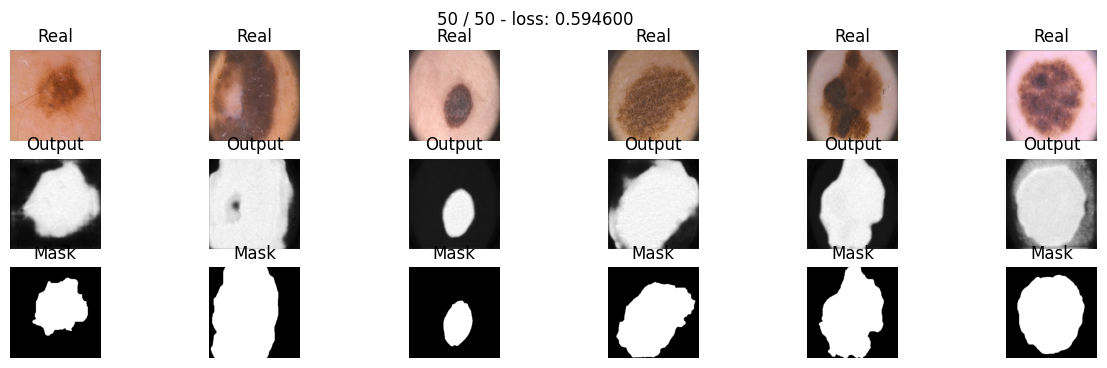

In [160]:
unet_boundary_hist = []
max_epochs = 50
optimaizer = optim.Adam(unet_model.parameters())
v_loss, t_loss, t_score = train(unet_model, optimaizer, boundary_loss, max_epochs, data_tr, data_val)
unet_boundary_hist.append(v_loss)
unet_boundary_hist.append(t_loss)
unet_boundary_hist.append(t_score)

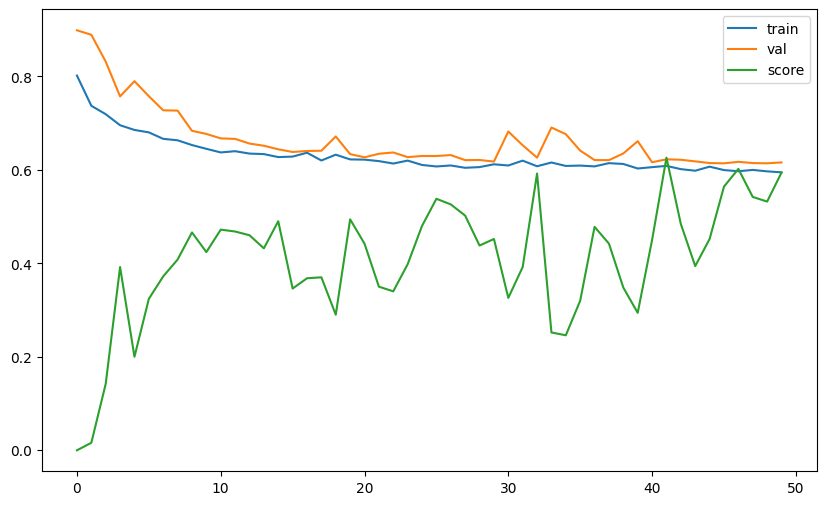

In [161]:
plt.figure(figsize=(10, 6))
plt.plot([float(loss) for loss in unet_boundary_hist[0]], label="train")
plt.plot([float(loss) for loss in unet_boundary_hist[1]], label="val")
plt.plot([float(loss) for loss in unet_boundary_hist[2]], label="score")
plt.legend()
plt.show()

In [163]:
print(max(unet_boundary_hist[2]))

0.6259999871253967


Новая модель путем изменения типа пулинга:

 **Max-Pooling** for the downsampling and **nearest-neighbor Upsampling** for the upsampling.

Down-sampling:

        conv = nn.Conv2d(3, 64, 3, padding=1)
        pool = nn.MaxPool2d(3, 2, padding=1)

Up-Sampling

        upsample = nn.Upsample(32)
        conv = nn.Conv2d(64, 64, 3, padding=1)

Замените max-pooling на convolutions с stride=2 и upsampling на transpose-convolutions с stride=2.


In [164]:
class UNet2(nn.Module):
    def __init__(self):
        super().__init__()

        # encoder (downsampling)
        # Each enc_conv/dec_conv block should look like this:
        # nn.Sequential(
        #     nn.Conv2d(...),
        #     ... (2 or 3 conv layers with relu and batchnorm),
        # )
        self.enc_conv0 = nn.Sequential(
            nn.Conv2d(3, 64, 3, padding = 1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 64, 3, padding = 1),
            nn.BatchNorm2d(64),
            nn.ReLU()
        )
        self.pool0 = nn.Conv2d(64, 64, kernel_size = 2, stride= 2)  # 256 -> 128

        self.enc_conv1 = nn.Sequential(
            nn.Conv2d(64, 128, 3, padding = 1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 128, 3, padding = 1),
            nn.BatchNorm2d(128),
            nn.ReLU()
        )
        self.pool1 = nn.Conv2d(128, 128, kernel_size = 2, stride= 2)# 128 -> 64

        self.enc_conv2 = nn.Sequential(
            nn.Conv2d(128, 256, 3, padding = 1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(256, 256, 3, padding = 1),
            nn.BatchNorm2d(256),
            nn.ReLU()
        )
        self.pool2 = nn.Conv2d(256, 256, kernel_size = 2, stride= 2) # 64 -> 32

        self.enc_conv3 = nn.Sequential(
            nn.Conv2d(256, 512, 3, padding = 1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(512, 512, 3, padding = 1),
            nn.BatchNorm2d(512),
            nn.ReLU()
        )
        self.pool3 = nn.Conv2d(512, 512, kernel_size = 2, stride= 2) # 32 -> 16

        # bottleneck
        self.bottleneck_conv = nn.Sequential(
            nn.Conv2d(512, 1024, 3, padding = 1),
            nn.BatchNorm2d(1024),
            nn.ReLU(),
            nn.Conv2d(1024, 512, 3, padding = 1),
            nn.BatchNorm2d(512),
            nn.ReLU()
        )

        # decoder (upsampling)
        self.upsample0 = nn.ConvTranspose2d(512, 512, 2, 2) # 16 -> 32
        self.dec_conv0 = nn.Sequential(
            nn.Conv2d(1024, 512, 3, padding = 1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(512, 256, 3, padding = 1),
            nn.BatchNorm2d(256),
            nn.ReLU()
        )

        self.upsample1 = nn.ConvTranspose2d(256, 256, 2, 2) # 32 -> 64
        self.dec_conv1 = nn.Sequential(
            nn.Conv2d(512, 256, 3, padding = 1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(256, 128, 3, padding = 1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
        )

        self.upsample2 = nn.ConvTranspose2d(128, 128, 2, 2) # 64 -> 128
        self.dec_conv2 = nn.Sequential(
            nn.Conv2d(256, 128, 3, padding = 1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 64, 3, padding = 1),
            nn.BatchNorm2d(64),
            nn.ReLU()
        )

        self.upsample3 = nn.ConvTranspose2d(64, 64, 2, 2) # 128 -> 256
        self.dec_conv3 = nn.Sequential(
            nn.Conv2d(128, 64, 3, padding = 1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 64, 3, padding = 1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 1, 1)
        )

    def forward(self, x):
        # encoder
        e0 = self.enc_conv0(x)
        x = self.pool0(e0)

        e1 = self.enc_conv1(x)
        x = self.pool1(e1)

        e2 = self.enc_conv2(x)
        x = self.pool2(e2)

        e3 = self.enc_conv3(x)
        x = self.pool3(e3)

        # bottleneck
        b = self.bottleneck_conv(x)

        # decoder

        d0 = self.dec_conv0(torch.cat((self.upsample0(b), e3), dim=1))
        d1 = self.dec_conv1(torch.cat((self.upsample1(d0), e2), dim=1))
        d2 = self.dec_conv2(torch.cat((self.upsample2(d1), e1), dim=1))
        d3 = self.dec_conv3(torch.cat((self.upsample3(d2), e0), dim=1))
        return d3

In [165]:
import gc
unet2_model = None
torch.cuda.empty_cache()
gc.collect()
torch.cuda.empty_cache()

In [166]:
unet2_model = UNet2().to(device)

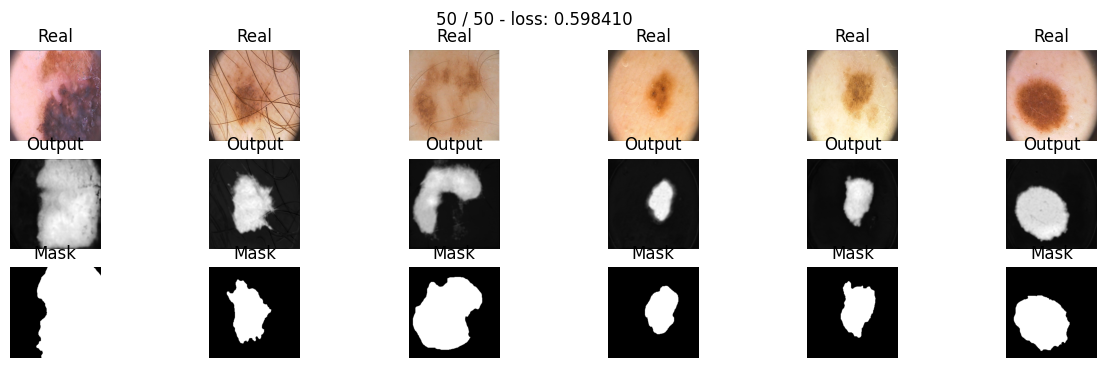

In [167]:
unet2_bce_hist = []
max_epochs = 50
optimaizer = optim.Adam(unet2_model.parameters())
v_loss, t_loss, t_score = train(unet2_model, optimaizer, bce_loss, max_epochs, data_tr, data_val)
unet2_bce_hist.append(v_loss)
unet2_bce_hist.append(t_loss)
unet2_bce_hist.append(t_score)

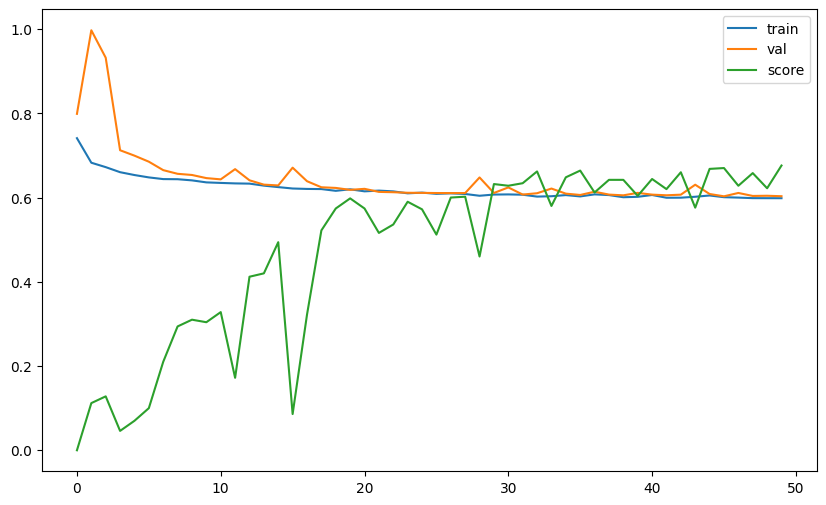

0.6760000288486481


In [168]:
plt.figure(figsize=(10, 6))
plt.plot([float(loss) for loss in unet2_bce_hist[0]], label="train")
plt.plot([float(loss) for loss in unet2_bce_hist[1]], label="val")
plt.plot([float(loss) for loss in unet2_bce_hist[2]], label="score")
plt.legend()
plt.show()

print(max(unet2_bce_hist[2]))

Примечание: можно прожолжить для dice_loss, focal_loss, boundary_loss. Но боюсь, что колаб сбросит многочасовую работу)

Сделайте вывод, какая из моделей лучше

# Отчет (6 баллов):
Ниже предлагается написать отчет о проделанно работе и построить графики для лоссов, метрик на валидации и тесте.
Если вы пропустили какую-то часть в задании выше, то вы все равно можете получить основную часть баллов в отчете, если правильно зададите проверяемые вами гипотезы.


Аккуратно сравните модели между собой и соберите наилучшую архитектуру. Проверьте каждую модель с различными лоссами. Мы не ограничиваем вас в формате отчета, но проверяющий должен отчетливо понять для чего построен каждый график, какие выводы вы из него сделали и какой общий вывод можно сделать на основании данных моделей. Если вы захотите добавить что-то еще, чтобы увеличить шансы получения максимального балла, то добавляйте отдельное сравнение.

Дополнительные комментарии:

Пусть у вас есть N обученных моделей.
- Является ли отчетом N графиков с 1 линей? Да, но очень низкокачественным, потому что проверяющий не сможет сам сравнить их.

- Является ли отчетом 1 график с N линиями? Да, но скорее всего таким образом вы отразили лишь один эффект. Этого мало, чтобы сделать досточно суждений по поводу вашей работа.

- Я проверял метрики на трейне, и привел в результате таблицу с N числами, что не так? ключейвой момент тут, что вы измеряли на трейне ваши метрики, уверены ли вы, что заивисмости останутся такими же на отложенной выборке?

- Я сделал отчет содержащий график лоссов и метрик, и у меня нет ошибок в основной части, но за отчет не стоит максимум, почему? Естестественно максимум баллов за отчет можно получить не за 2 графика (даже при условии их полной правильности). Проверяющий хочет видеть больше сравнений моделей, чем метрики и лоссы (особенно, если они на трейне).

Советы: попробуйте правильно поставить вопрос на который вы себе отвечаете и продемонстрировать таблицу/график, помогающий проверяющему увидеть ответ на этот вопрос. Пример: Ваня хочет узнать, с каким из 4-х лоссов модель (например, U-Net) имеет наилучшее качество. Что нужно сделать Ване? Обучить 4 одинаковых модели с разными лосс функциями. И измерить итогововое качество. Продемонстрировать результаты своих измерений и итоговый вывод. (warning: конечно же, это не идеально ответит на наш вопрос, так как мы не учитываем в экспериментах возможные различные типы ошибок, но для первого приближения этого вполне достаточно).

Примерное время на подготовку отчета 1 час, он содержит сравнеение метрик, график лоссов, выбор лучших моделей из нескольких кластеров и выбор просто лучшей модели, небольшой вывод по всему дз, возможно сравнение результирующих сегментаций, времени или числа параметров модели, проявляйте креативность.

Графики:

In [ ]:
import matplotlib.pyplot as plt

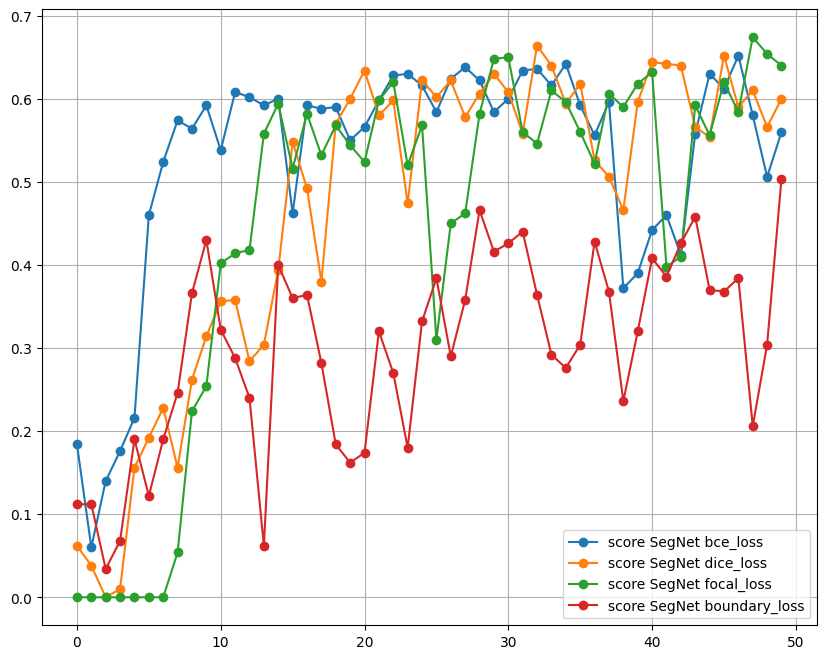

In [171]:
plt.figure(figsize=(10, 8))

plt.plot([float(loss) for loss in segnet_bce_hist[2]], label="score SegNet bce_loss", marker='o')
plt.plot([float(loss) for loss in segnet_dice_hist[2]], label="score SegNet dice_loss", marker='o')
plt.plot([float(loss) for loss in segnet_focal_hist[2]], label="score SegNet focal_loss", marker='o')
plt.plot([float(loss) for loss in segnet_boundary_hist[2]], label="score SegNet boundary_loss", marker='o')

plt.legend()
plt.grid(True)
plt.show()

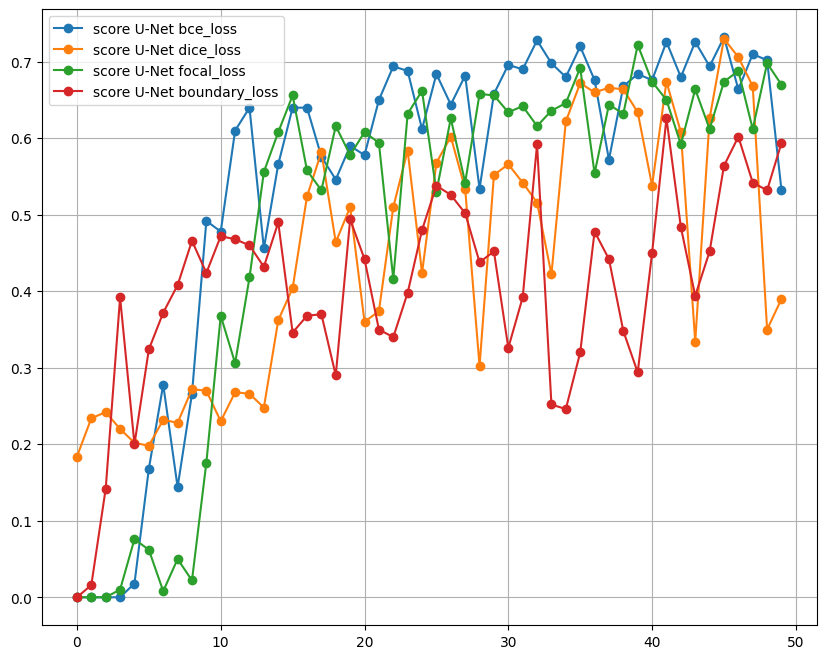

In [172]:
plt.figure(figsize=(10, 8))

plt.plot([float(loss) for loss in unet_bce_hist[2]], label="score U-Net bce_loss", marker='o')
plt.plot([float(loss) for loss in unet_dice_hist[2]], label="score U-Net dice_loss", marker='o')
plt.plot([float(loss) for loss in unet_focal_hist[2]], label="score U-Net focal_loss", marker='o')
plt.plot([float(loss) for loss in unet_boundary_hist[2]], label="score U-Net boundary_loss", marker='o')

plt.legend()
plt.grid(True)
plt.show()

**Выводы**:



* U-Net, в среднем, выходит на более-менее стабильный score быстрее, чем SegNet и при этом имеет более высокий score.

* Boundary_loss показала себя заметно хуже других функций потерь. Bce_loss и focal_loss показали наилучшие результаты. Dice_loss в среднем немного хуже.

* В конечном итоге можно считать комбинации UNet с bce_loss или с focal loss наиболее результативными по качеству и скорости схождения.